In [1]:
from IPython import get_ipython
from IPython.display import display
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, MobileNetV2, ResNet50
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from google.colab import drive
import cv2
import os
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Load dataset dari Google Drive
from google.colab import drive
import os

# Restart the runtime and run this cell again. It will prompt for authentication
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/Histopatologi 5%'  # Ganti dengan path ke folder dataset Anda

Mounted at /content/drive


In [3]:
# Define paths for IDC (-) and IDC (+) categories
N_IDC_path = os.path.join(data_path, '0')  # Assuming '0' folder for IDC (-)
P_IDC_path = os.path.join(data_path, '1')  # Assuming '1' folder for IDC (+)

# Get the list of image file paths for IDC (-) and IDC (+)
N_IDC = [os.path.join(N_IDC_path, filename) for filename in os.listdir(N_IDC_path) if filename.endswith(('.png', '.jpg', '.jpeg'))]
P_IDC = [os.path.join(P_IDC_path, filename) for filename in os.listdir(P_IDC_path) if filename.endswith(('.png', '.jpg', '.jpeg'))]

non_img_arr = []
can_img_arr = []

for img in N_IDC:
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(n_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    non_img_arr.append([n_img_size, 0])

for img in P_IDC:
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img_size = cv2.resize(c_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    can_img_arr.append([c_img_size, 1])

In [4]:
print(len(non_img_arr))
print(len(can_img_arr))
print(len(non_img_arr) + len(can_img_arr))

10304
2456
12760


In [5]:
print(len(N_IDC))
print(len(P_IDC))

10304
2456


In [6]:
import random # import the random module

X = []
y = []

breast_img_arr = non_img_arr + can_img_arr
random.shuffle(breast_img_arr)

for features, label in breast_img_arr:
    X.append(features)
    y.append(label)

X =  np.array(X)
y = np.array(y)

In [7]:
def describeData(a,b):
    print('total number of images:{}'.format(len(a)))
    print('total number of IDC(-) Images:{}'.format(np.sum(b==0)))
    print('total number of IDC(+) Images:{}'.format(np.sum(b==1)))
    print('image shape(Width, height, channels):{}'.format(a[0].shape))
describeData(X,y)

total number of images:12760
total number of IDC(-) Images:10304
total number of IDC(+) Images:2456
image shape(Width, height, channels):(50, 50, 3)


In [8]:
X = X /255.0

In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Membagi data menjadi train (80%) dan temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Membagi temp menjadi validation (10%) dan test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Konversi label ke format one-hot encoding
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)


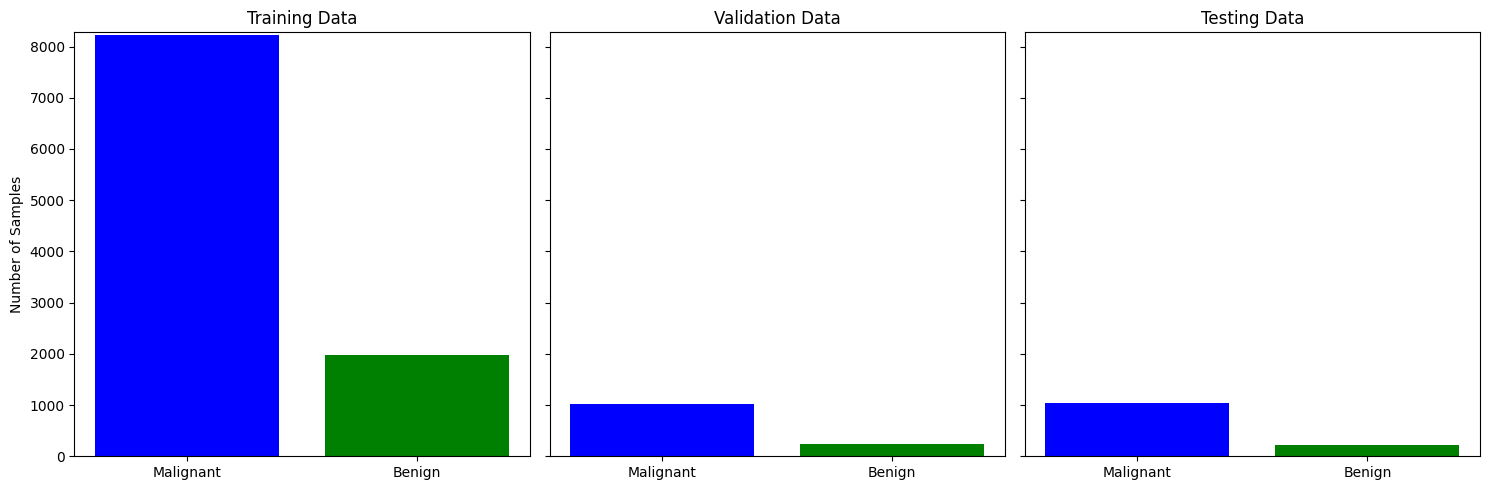

In [10]:
# Labels for the classes
classes = ['Malignant', 'Benign']

# Calculate class counts for each dataset
train_counts = np.unique(np.argmax(y_train, axis=1), return_counts=True)[1]
val_counts = np.unique(np.argmax(y_val, axis=1), return_counts=True)[1]
test_counts = np.unique(np.argmax(y_test, axis=1), return_counts=True)[1]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Plot for training data
axes[0].bar(classes, train_counts, color=['blue', 'green'])
axes[0].set_title('Training Data')
axes[0].set_ylabel('Number of Samples')
axes[0].set_ylim(0, max(train_counts.max(), val_counts.max(), test_counts.max()) + 50)

# Plot for validation data
axes[1].bar(classes, val_counts, color=['blue', 'green'])
axes[1].set_title('Validation Data')

# Plot for testing data
axes[2].bar(classes, test_counts, color=['blue', 'green'])
axes[2].set_title('Testing Data')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [11]:
print("Training Data Shape:", X_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (10208, 50, 50, 3)
Validation Data Shape: (1276, 50, 50, 3)
Testing Data Shape: (1276, 50, 50, 3)


In [12]:
train_datagen = ImageDataGenerator(rotation_range= 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

In [13]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(50, 50, 3))
for layer in base_model.layers:
    layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [14]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(), # Add GlobalAveragePooling2D layer
    tf.keras.layers.Dense(16, activation='relu'), # Add a Dense layer with 16 units
    tf.keras.layers.Dense(2, activation='softmax') # Output layer with 2 units (for binary classification)
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2, 2, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        32,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,620,530 (90.11 MB)

 Trainable params: 32,818 (128.20 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [15]:
model.compile(optimizer = 'adam', loss = BinaryCrossentropy(), metrics = ['accuracy'])

In [16]:
history = model.fit(train_generator, epochs=50, validation_data=(X_val, y_val)
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 172s 508ms/step - accuracy: 0.8063 - loss: 0.5035 - val_accuracy: 0.8072 - val_loss: 0.4842
Epoch 2/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 158s 496ms/step - accuracy: 0.8013 - loss: 0.4932 - val_accuracy: 0.8072 - val_loss: 0.4804
Epoch 3/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 162s 507ms/step - accuracy: 0.8095 - loss: 0.4726 - val_accuracy: 0.8072 - val_loss: 0.4685
Epoch 4/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 162s 507ms/step - accuracy: 0.8075 - loss: 0.4672 - val_accuracy: 0.8111 - val_loss: 0.4561
Epoch 5/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 162s 508ms/step - accuracy: 0.8111 - loss: 0.4510 - val_accuracy: 0.8135 - val_loss: 0.4398
Epoch 6/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 162s 508ms/step - accuracy: 0.8042 - loss: 0.4446 - val_accuracy: 0.8143 - val_loss: 0.4313
Epoch 7/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 201s 503ms/step - accuracy: 0.8101 - loss: 0.4268 - val_accuracy: 0.8276 - val_loss: 0.4529
Epoch 8/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 155s 486ms/step - accuracy: 0.8299 -

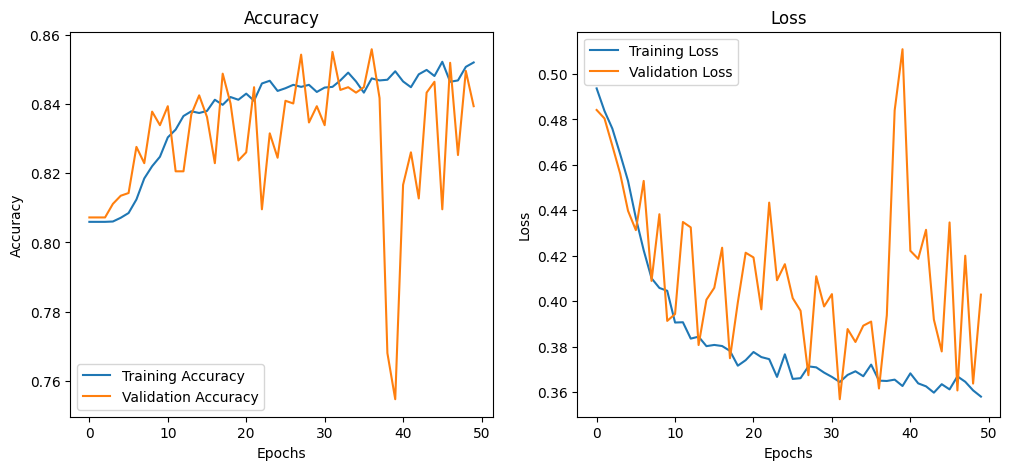

In [17]:

# Visualisasi Akurasi dan Loss
plt.figure(figsize=(12, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [18]:
model.evaluate(X_test, y_test)

40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 406ms/step - accuracy: 0.8345 - loss: 0.3948


[0.377651572227478, 0.8448275923728943]

40/40 ━━━━━━━━━━━━━━━━━━━━ 22s 489ms/step
Test set Classification_Report:



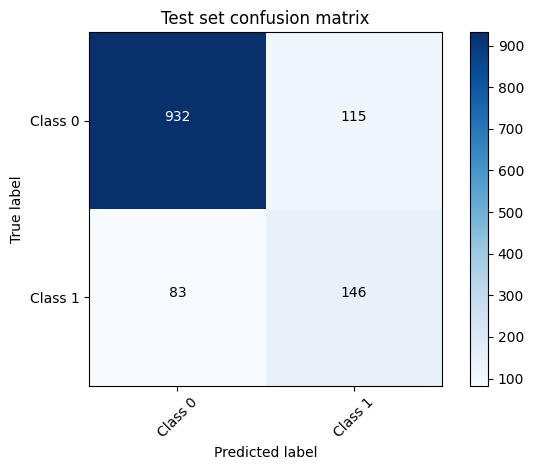

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'  # Use integer formatting for confusion matrix values
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Assuming 'model' is your trained Keras model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels
y_true_classes = np.argmax(y_test, axis=1)  # Convert true labels to class labels

# Compute confusion matrix
test_cm = confusion_matrix(y_true_classes, y_pred_classes)

# Define class labels (assuming you have 2 classes: 0 and 1)
cm_labels = ['Class 0', 'Class 1']  # Replace with your actual class names

# Plot confusion matrix
print(f"Test set Classification_Report:\n")
plot_confusion_matrix(test_cm, cm_labels, 'Test set confusion matrix')

40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 407ms/step
              precision    recall  f1-score   support

           0       0.92      0.89      0.90      1047
           1       0.56      0.64      0.60       229

    accuracy                           0.84      1276
   macro avg       0.74      0.76      0.75      1276
weighted avg       0.85      0.84      0.85      1276



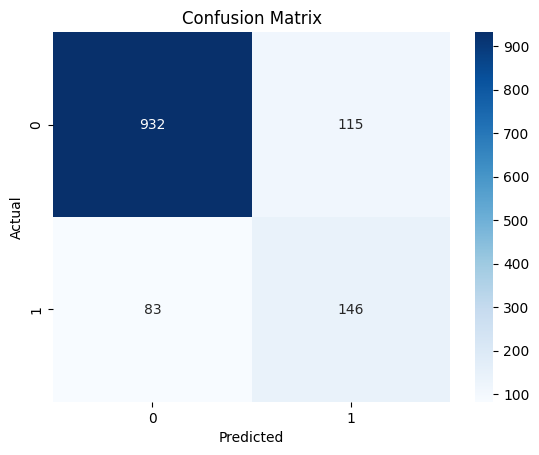

In [20]:
# Evaluasi
y_pred_probs = model.predict(X_test) # Get predicted probabilities
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels (0 or 1)
y_true = np.argmax(y_test, axis=1) # Use y_test and extract the true labels

# Import classification_report if not already imported
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_classes)) # Use predicted class labels

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns  # Import seaborn if not already imported

cm = confusion_matrix(y_true, y_pred_classes)  # Use predicted class labels
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 406ms/step
AUC Score: 0.8518


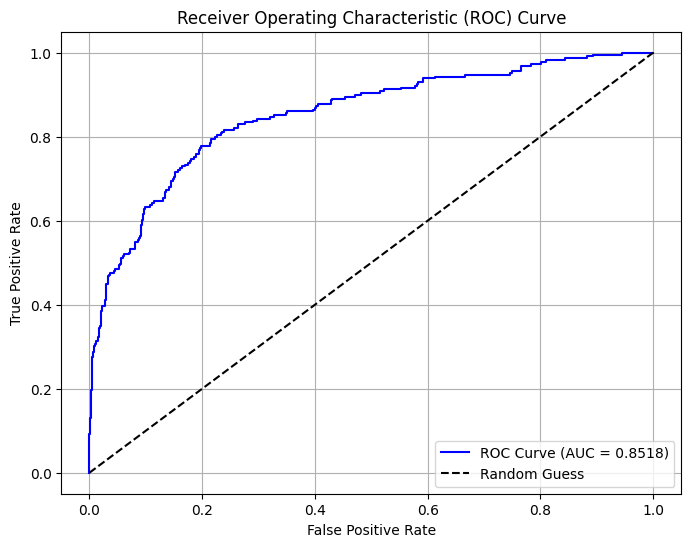

In [21]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Misal ini adalah prediksi model
y_pred_probs = model.predict(X_test)[:, 1]  # Ambil probabilitas untuk kelas 1 (kanker)

# Jika y_test masih one-hot encoded, ubah ke label
y_true = np.argmax(y_test, axis=1)

# Hitung AUC
auc_score = roc_auc_score(y_true, y_pred_probs)
print(f"AUC Score: {auc_score:.4f}")

# Hitung nilai fpr, tpr untuk ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()
